<a href="https://colab.research.google.com/github/evakato/ComputerVision4/blob/main/cv4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
device = (
    #Nvidia GPU
    "cuda" 
    if torch.cuda.is_available()
    #Apple GPU
    else "mps"
    if torch.backends.mps.is_available()
    #Other
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


1. Import the Fashion MNIST dataset including the data labels. This would import two sets (training set and test set). Create a third set (validation set) by splitting the training set into two (training set and validation set) for validation purposes. Decide what a good ratio of training/validation is, and motivate your choice. You should use the validation set to evaluate the different choices you make when building your CNNs. Keep in mind that the test set will only be used at the very final stage and will not be included in the validation step.

In [4]:
from torchvision.transforms import ToTensor
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
from matplotlib import pyplot as plt

#NOTE: data is not normalised yet
train_data = datasets.FashionMNIST('Data', download=True, train=True, transform=ToTensor())
test_data = datasets.FashionMNIST('Data', download=True, train=False, transform=ToTensor())

splitlength = [50000,10000] 
#NOTE: This needs to be changed to be calculated using a percentage if we are going to have variable data lenghts (due to e.g. data augmentation)
train_data, val_data = random_split(train_data, splitlength)

batch_size = 32
train_dataloader = DataLoader(train_data, batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size, shuffle=True)

torch.Size([1, 28, 28]) 7


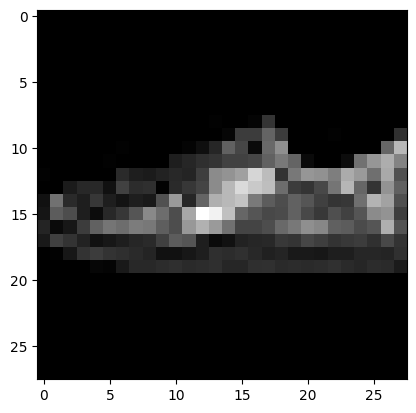

In [5]:
image, label = train_data[0]
print(image.shape, label)
plt.imshow(image[0], cmap = 'gray')

2. Recreate the LeNet-5 architecture as your baseline. The model takes as input a greyscale image of size 28x28x1 and has 10 outputs, one for each class. Make sure all parameters (number of neurons, number and size of kernels) is the same as in the original architecture. You may assume that no zero-padding was applied. The model is trained using cross-entropy loss, Adam optimizer with a learning rate of 0.001. Use torch.nn.init.kaiming_uniform to initialize your weights. Use a batch size of 32, unless your hardware doesn't allow you to. Then reduce the size accordingly.


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.init import kaiming_uniform_, zeros_

class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        # Convolutional and pooling layers
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),  # 1 input channel, 6 output channels, 5x5 kernel
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5), # 6 input channels, 16 output channels, 5x5 kernel
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
        )
        # Fully connected layers
        self.dense = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16 * 4 * 4, 120),  # 16 channels, 4x4 feature map size 
            #NOTE: isn't this supposed to be 16*5*5?
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10),  # 10 output classes
        )

        self.apply(self.weights_init)
    
    def forward(self, x):
        # Convolutional layers with ReLU activation and max pooling
        x = self.conv(x)
        # Fully connected layers with ReLU activation
        y = self.dense(x)
        return y

    def weights_init(self, m):
        if isinstance(m, nn.Conv2d):
            torch.nn.init.kaiming_uniform_(m.weight)
            torch.nn.init.zeros_(m.bias)
        if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_uniform_(m.weight)
            torch.nn.init.zeros_(m.bias)

In [7]:
from torchkeras import summary

model = LeNet5()

def check_weights():
    for param in model.parameters():
        print(param.data)

def summarize(model):
    summary(model=model, input_shape=(1,28,28))

summarize(model)


--------------------------------------------------------------------------
Layer (type)                            Output Shape              Param #
Conv2d-1                             [-1, 6, 24, 24]                  156
ReLU-2                               [-1, 6, 24, 24]                    0
AvgPool2d-3                          [-1, 6, 12, 12]                    0
Conv2d-4                              [-1, 16, 8, 8]                2,416
ReLU-5                                [-1, 16, 8, 8]                    0
AvgPool2d-6                           [-1, 16, 4, 4]                    0
Flatten-7                                  [-1, 256]                    0
Linear-8                                   [-1, 120]               30,840
ReLU-9                                     [-1, 120]                    0
Linear-10                                   [-1, 84]               10,164
ReLU-11                                     [-1, 84]                    0
Linear-12                            

In [41]:
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def train(loader, model, criterion, optimizer):
    size = len(loader.dataset)
    model.train()

    for n, batch in enumerate(tqdm(loader)):
        X,y = batch
        optimizer.zero_grad()
        
        pred = model(X)
        loss = criterion(pred, y)

        loss.backward()
        optimizer.step()
    

def test(loader, model, criterion):
    size = len(loader.dataset)
    batches = len(loader)
    total_loss = 0
    correct = 0
    y_pred = []
    y_true = []

    with torch.no_grad():
        for batch in loader:
            X,y = batch
            pred = model(X)
            
            total_loss += criterion(pred, y).item()
            #correct += (pred.argmax(1)==y).type(torch.float).sum().item()

            y = y.data.numpy()
            y_true.extend(y)
            pred = pred.argmax(1).data.numpy()
            y_pred.extend(pred)

    loss = total_loss / batches
    accuracy = accuracy_score(y_true, y_pred)

    print(f"loss: {loss}\naccuracy: {accuracy}")
    return y_true, y_pred
        

Epoch 1
----------------
loss: 0.315127328835642
accuracy: 0.8833
----------------


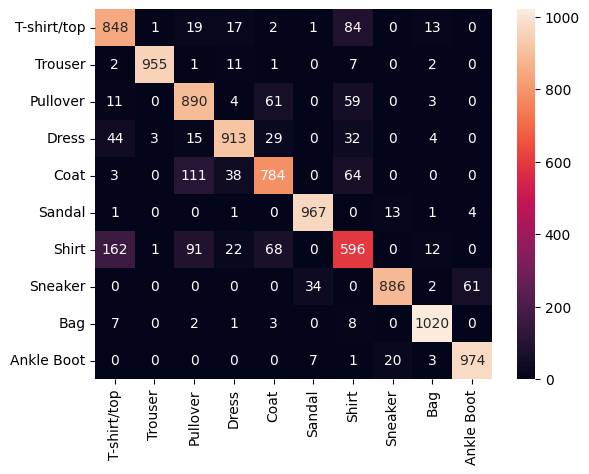

In [83]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn
import pandas as pd

#model = LeNet5()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 1

for i in range(epochs):
    print(f"Epoch {i+1}\n----------------")
    #train(loader=train_dataloader, model=model, criterion=criterion, optimizer=optimizer)
    y_true, y_pred = test(loader=val_dataloader, model=model, criterion=criterion)
    print("----------------")

classes = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]

def evaluate(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    conf_matrix = pd.DataFrame(conf_matrix, [i for i in classes], [i for i in classes])
    sn.heatmap(conf_matrix, annot=True, fmt= 'g')

evaluate(y_true,y_pred)

3. Now create four model variants. Each model may differ from the previous model by only one aspect, such that we can compare each pair of subsequent models pair-wise. An aspect should be a meaningful property, e.g., change the type of one layer (convolution --> pooling, etc.), add one layer, use dropout, change your activation function, change the number or size of your kernels, change the learning rate, etc. No use of any merging, attention, recurrent or locally-connected layers. Your variants should be aimed at getting a better performance. We keep the batch sizes fixed so choose a number and keep it constant for all models (including the baseline model).

In [ ]:
'''
options:

Dropout
Learning rate
Activation function
More/Less layers
Pooling type
Normalisation

loss_fn/optimizer/weight init (I dont think this will do much)

grid-search?
'''